In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import time
from scipy.stats import multivariate_normal

In [2]:
def initialize_centroids_randomly(data, num_clusters):

    # randomly initialize the centroids
    # select any k points from the data as the initial centroids
    random_indices = random.sample(range(len(data)), num_clusters)
    centroids = data[random_indices]    

    return centroids

In [3]:
def initialize_centroids_plusplus(data, num_clusters):

    #select the first centroid randomly
    centroids = []
    first_centroid = data[random.randint(0, len(data)-1)]
    centroids.append(first_centroid)

    # calculate the distance between all other points and already selected centroids
    # take the minimum of the distances between each point and the centroids
    # select the next centroid based on the probability of the distance
    for _ in range(num_clusters - 1):
        distances = np.zeros(len(data))
        for i, point in enumerate(data):
            point_distances = []
            for centroid in centroids:
                dist = np.linalg.norm(point - centroid)
                point_distances.append(dist)
            distances[i] = min(point_distances)
        
        probabilities = distances / np.sum(distances)
        new_centroid_index = np.random.choice(len(data), p=probabilities)
        centroids.append(data[new_centroid_index])
    
    return np.array(centroids)

In [4]:
def update_centroids(data, centroids):

    # calculate the distance between each point and all the centroids
    # assign each data point to the closest centroid
    cluster_indices = np.zeros(len(data), dtype=int)
    
    for i, point in enumerate(data):
        distances = []
        for centroid in centroids:
            dist = np.linalg.norm(point - centroid)
            distances.append(dist)
        cluster_indices[i] = np.argmin(distances)
    
    # update the centroids
    # calculate the mean of the data points in each cluster
    # set the mean as the new centroid
    new_centroids = []
    clusters = []
    for i in range(len(centroids)):
        cluster_points = []
        for j, point in enumerate(data):
            if cluster_indices[j] == i:
                cluster_points.append(point)
        
        if len(cluster_points) > 0:
            new_centroid = np.mean(cluster_points, axis=0)
        else:
            new_centroid = centroids[i]  # Keep the old centroid if the cluster is empty
        
        new_centroids.append(new_centroid)
        clusters.append(np.array(cluster_points))
    
    return np.array(new_centroids), clusters

In [ ]:
def k_means_clustering(data, num_clusters):

    centroids = initialize_centroids_randomly(data, num_clusters)
    
    while True:
        prev_centroids = centroids.copy()
        centroids, clusters = update_centroids(data, centroids)
        
        all_close = True
        for i in range(len(centroids)):
            if not np.allclose(prev_centroids[i], centroids[i]):
                all_close = False
                break
        
        if all_close:
            break

    return centroids, clusters

In [22]:
def k_meanspp_clustering(data, num_clusters):

    centroids = initialize_centroids_plusplus(data, num_clusters)
    
    while True:
        prev_centroids = centroids.copy()
        centroids, clusters = update_centroids(data, centroids)
        
        all_close = True
        for i in range(len(centroids)):
            if not np.allclose(prev_centroids[i], centroids[i]):
                all_close = False
                break
        
        if all_close:
            break

    return centroids, clusters

In [6]:
def gmm_clustering(data, num_clusters, tol=1e-4):

    n_samples, n_features = data.shape
    k = num_clusters
    
    # initialize parameters
    weights = np.ones(k) / k
    means = data[np.random.choice(n_samples, k, replace=False)]
    covariances = [np.eye(n_features) for _ in range(k)]
    
    # initialize log-likelihood
    log_likelihood = -np.inf

    while True:

        # Expectation-step
        # given the current parameter estimates, compute the responsibilities
        responsibilities = np.zeros((n_samples, k))
        for j in range(k):
            responsibilities[:, j] = weights[j] * multivariate_normal.pdf(data, mean=means[j], cov=covariances[j])
        responsibilities_sum = responsibilities.sum(axis=1)

        for i in range(n_samples):
            responsibilities[i, :] /= responsibilities_sum[i]
        
        # Maximization-step
        # given the current responsibilities, compute the new parameter estimates
        N_k = np.sum(responsibilities, axis=0)
        weights = N_k / n_samples
        
        for j in range(k):
            means[j] = np.zeros(n_features)
            for i in range(n_samples):
                means[j] += responsibilities[i, j] * data[i]
            means[j] /= N_k[j]
        
        for j in range(k):
            covariances[j] = np.zeros((n_features, n_features))
            for i in range(n_samples):
                diff = data[i] - means[j]
                covariances[j] += responsibilities[i, j] * np.outer(diff, diff)
            covariances[j] /= N_k[j]
        
        # Compute log-likelihood
        new_log_likelihood = 0
        for i in range(n_samples):
            sum_prob = 0
            for j in range(k):
                sum_prob += weights[j] * multivariate_normal.pdf(data[i], mean=means[j], cov=covariances[j])
            new_log_likelihood += np.log(sum_prob)
        
        # Check for convergence
        if np.abs(new_log_likelihood - log_likelihood) < tol:
            break
        
        log_likelihood = new_log_likelihood
    
    # Assign labels
    labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        labels[i] = np.argmax(responsibilities[i])
    
    clusters = [data[labels == i] for i in range(k)]
    return means, clusters

In [7]:
def generate_blobs(num_samples, num_features, num_clusters, cluster_std=1.0):
    return make_blobs(n_samples=num_samples, n_features=num_features, centers=num_clusters, cluster_std=cluster_std)

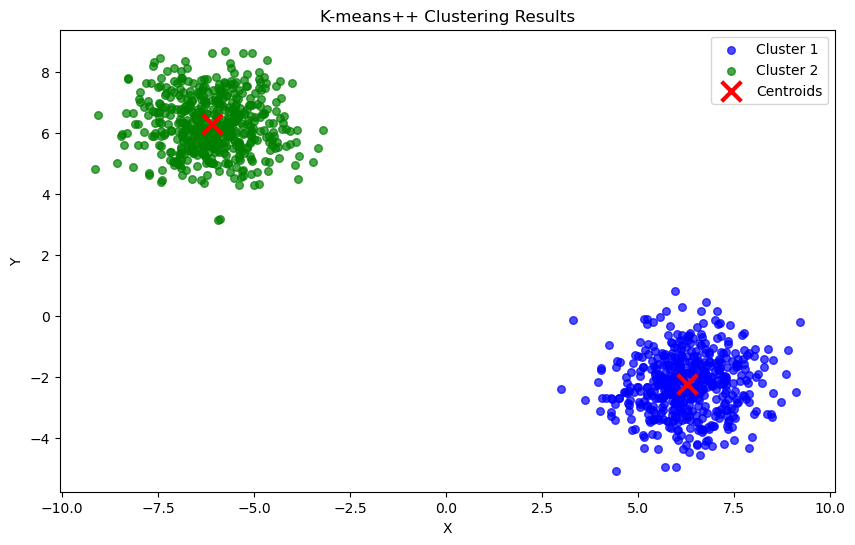

In [15]:
# simple test

num_clusters = 2 # number of clusters
num_samples = 1000 # number of data points
num_features = 2 # dimension of the data

X, _ = generate_blobs(num_samples=1000, num_features=2, num_clusters=num_clusters)

# run k-means clustering
# centroids, clusters = k_means_clustering(X, num_clusters
#                                         # init_method='kmeans++'
#                                         )

centroids, clusters = gmm_clustering(X, num_clusters)

# Plot results
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], c=colors[i], s=30, alpha=0.7, label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.legend()
plt.title('K-means++ Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [19]:
def run_clustering_trials(num_clusters, num_samples, num_features, num_trials=10, method='kmeans'):

    X, _ = generate_blobs(num_samples=num_samples, num_features=num_features, num_clusters=num_clusters)

    convergence_times = []
    for i in range(num_trials):

        print(f"Trial: {i+1}")

        if method == 'kmeans':
            start_time = time.time()
            k_means_clustering(X, num_clusters)
            end_time = time.time()
        elif method == 'kmeans++':
            start_time = time.time()
            k_meanspp_clustering(X, num_clusters)
            end_time = time.time()
        elif method == 'gmm':
            start_time = time.time()
            gmm_clustering(X, num_clusters)
            end_time = time.time()
        else:
            raise ValueError("Invalid method. Choose 'kmeans', 'kmeans++', or 'gmm'")

        convergence_times.append(end_time - start_time)

    avg_time = np.mean(convergence_times)
        
    return avg_time


Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

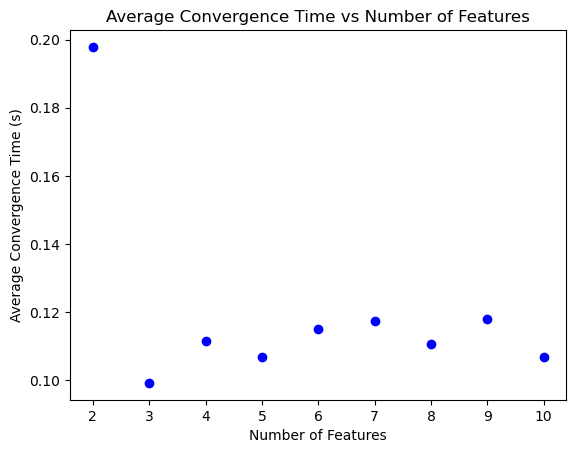

In [28]:
# convergence times vs number of features
# kmeans 3 clusters
# 1000 trials

num_clusters = 3 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 1000 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

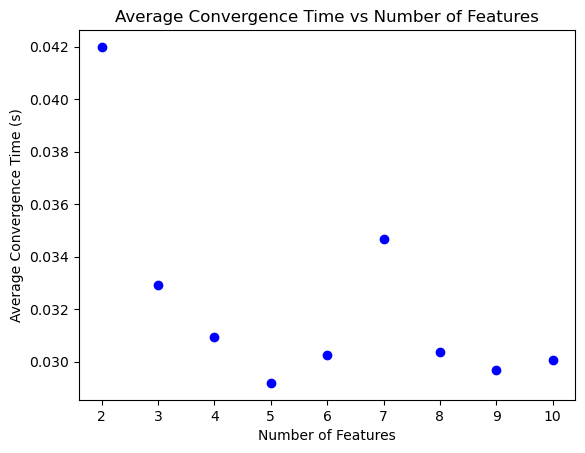

In [27]:
# convergence times vs number of features
# kmeans 2 clusters

num_clusters = 2 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

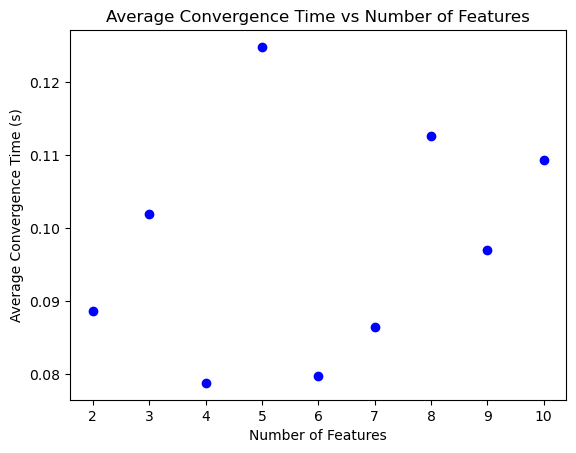

In [20]:
# convergence times vs number of features
# kmeans 3 clusters

num_clusters = 3 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

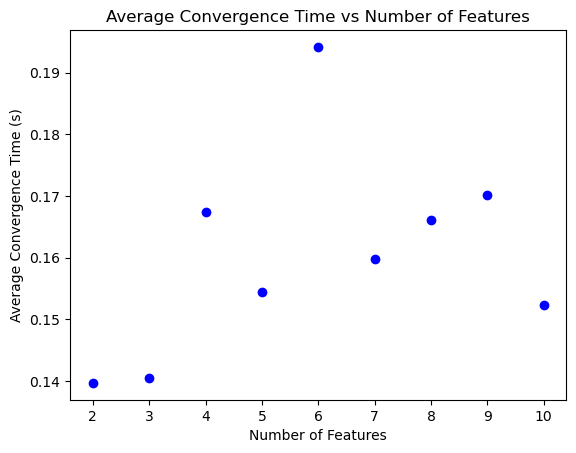

In [17]:
# convergence times vs number of features
# kmeans 4 clusters

num_clusters = 4 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

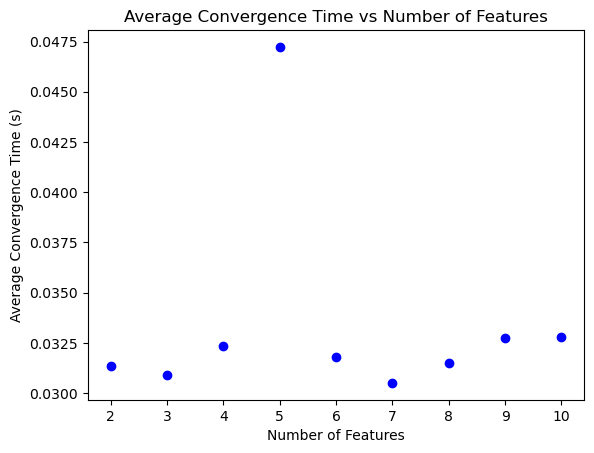

In [24]:
# convergence times vs number of features
# kmeans++ 2 clusters

num_clusters = 2 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans++')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

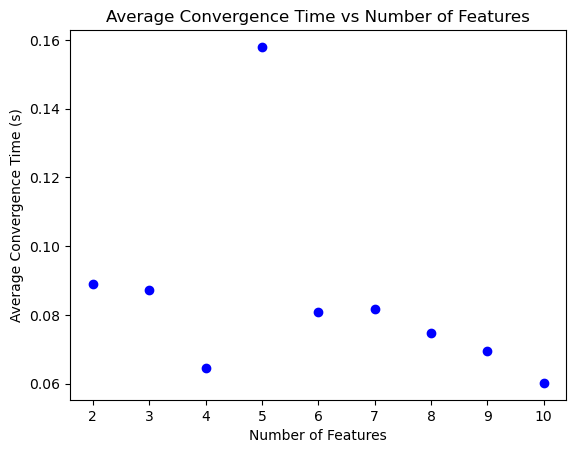

In [25]:
# convergence times vs number of features
# kmeans++ 3 clusters

num_clusters = 3 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans++')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Trial: 11
Trial: 12
Trial: 13
Trial: 14
Trial: 15
Trial: 16
Trial: 17
Trial: 18
Trial: 19
Trial: 20
Trial: 21
Trial: 22
Trial: 23
Trial: 24
Trial: 25
Trial: 26
Trial: 27
Trial: 28
Trial: 29
Trial: 30
Trial: 31
Trial: 32
Trial: 33
Trial: 34
Trial: 35
Trial: 36
Trial: 37
Trial: 38
Trial: 39
Trial: 40
Trial: 41
Trial: 42
Trial: 43
Trial: 44
Trial: 45
Trial: 46
Trial: 47
Trial: 48
Trial: 49
Trial: 50
Trial: 51
Trial: 52
Trial: 53
Trial: 54
Trial: 55
Trial: 56
Trial: 57
Trial: 58
Trial: 59
Trial: 60
Trial: 61
Trial: 62
Trial: 63
Trial: 64
Trial: 65
Trial: 66
Trial: 67
Trial: 68
Trial: 69
Trial: 70
Trial: 71
Trial: 72
Trial: 73
Trial: 74
Trial: 75
Trial: 76
Trial: 77
Trial: 78
Trial: 79
Trial: 80
Trial: 81
Trial: 82
Trial: 83
Trial: 84
Trial: 85
Trial: 86
Trial: 87
Trial: 88
Trial: 89
Trial: 90
Trial: 91
Trial: 92
Trial: 93
Trial: 94
Trial: 95
Trial: 96
Trial: 97
Trial: 98
Trial: 

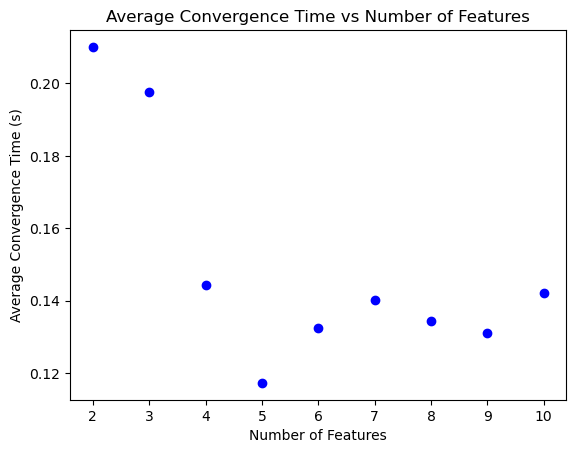

In [26]:
# convergence times vs number of features
# kmeans++ 4 clusters

num_clusters = 4 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 100 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='kmeans++')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()

Number of Features: 2
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 87.96605212688446
Number of Features: 3
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 35.82197573184967
Number of Features: 4
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 22.400090384483338
Number of Features: 5
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 17.57949302196503
Number of Features: 6
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 28.962617182731627
Number of Features: 7
Trial: 1
Trial: 2
Trial: 3
Trial: 4
Trial: 5
Trial: 6
Trial: 7
Trial: 8
Trial: 9
Trial: 10
Average Convergence Time: 12.231340861320495
Number of Features: 8
Trial: 1
Trial: 2
Trial: 3
Trial:

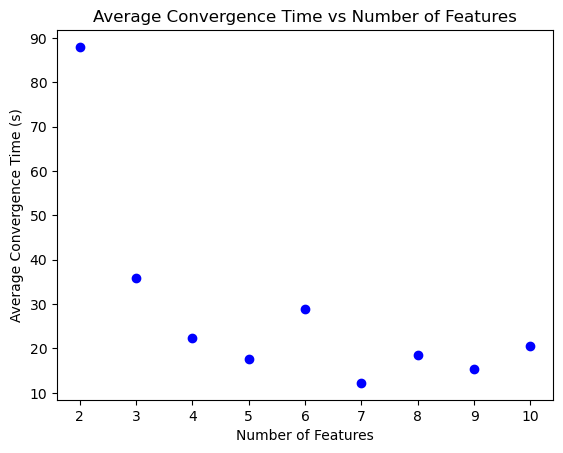

In [9]:
# convergence times vs number of features
# gmm 4 clusters

num_clusters = 4 # number of clusters
num_samples = 1000 # number of data points
num_features_list = range(2, 11) # dimension of the data
num_trials = 10 # number of trials

avg_time_list = np.zeros(len(num_features_list))
for i, num_features in enumerate(num_features_list):
    print(f"Number of Features: {num_features}")
    avg_time = run_clustering_trials(num_clusters, num_samples, num_features, num_trials, method='gmm')
    avg_time_list[i] = avg_time
    print(f"Average Convergence Time: {avg_time}")

# plot the results
plt.plot(num_features_list, avg_time_list, 'bo')
plt.xlabel('Number of Features')
plt.ylabel('Average Convergence Time (s)')
plt.title('Average Convergence Time vs Number of Features')
plt.show()